# **Email Assistant**

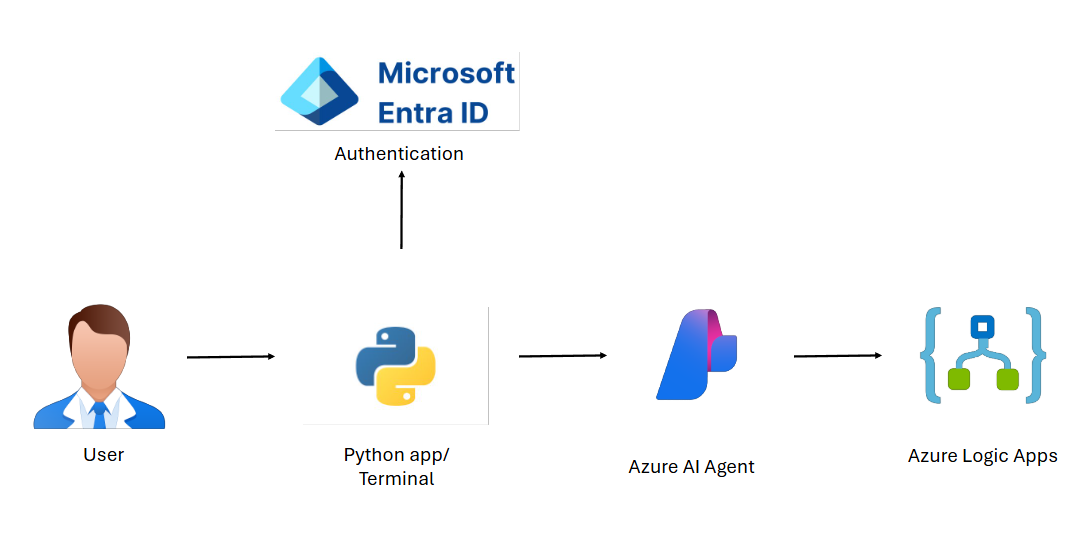

In [1]:
#!pip install azure-identity==1.23.0 azure-ai-projects==1.0.0b12 requests urllib3  load_dotenv


In [2]:
# ==============================================================================
# AZURE AI EMAIL ASSISTANT - TUTORIAL (NO CLASSES)
# ==============================================================================
# This application demonstrates how to build an AI-powered email assistant
# using Azure AI Services and Logic Apps for email delivery.

# Import required libraries
from azure.identity import ClientSecretCredential  # For Azure authentication
from azure.ai.projects import AIProjectClient      # For Azure AI Project interactions
from azure.ai.agents.models import ListSortOrder   # For sorting AI agent messages
import time                                         # For polling delays
import requests                                     # For HTTP requests to Logic Apps
import json                                         # For JSON parsing
import re                                          # For regular expressions
from urllib.parse import urlparse, parse_qs       # For URL parsing
import os

# ==============================================================================
# CONFIGURATION SECTION
# ==============================================================================
# Azure AI Project Configuration - Replace with your own values

import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
AZURE_ENDPOINT = os.getenv("PROJECT_ENDPOINT")
LOGIC_APPS_FULL_URL = os.getenv("LOGIC_APPS_FULL_URL")

def send_email_function(email_to, email_subject, email_body):
    """Send email via Logic Apps - registered as AI tool"""
    try:
        parsed = urlparse(LOGIC_APPS_FULL_URL)
        response = requests.post(
            f"{parsed.scheme}://{parsed.netloc}{parsed.path}",
            params={k: v[0] for k, v in parse_qs(parsed.query).items()},
            json={"email_to": email_to, "email_subject": email_subject, "email_body": email_body},
            timeout=30
        )
        return "✅ Email sent!" if response.status_code in [200, 202] else f"❌ Failed: {response.status_code}"
    except Exception as e:
        return f"❌ Error: {str(e)}"

def create_agent(client):
    """Create email assistant with Logic Apps tool"""
    return client.agents.create_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],
        name="Email-Assistant",
        instructions="""Email Assistant. Flow: Get recipient → subject → body → show preview → confirm → send.

            Preview format:
            📧 EMAIL PREVIEW:
            ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
            📩 TO: [recipient]
            📝 SUBJECT: [subject]
            ✉️ MESSAGE: [body]
            ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

            Would you like me to send this email?""",
        tools=[{
            "type": "function",
            "function": {
                "name": "send_email",
                "description": "Send email after user confirms",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "email_to": {"type": "string", "description": "Recipient email"},
                        "email_subject": {"type": "string", "description": "Email subject"},
                        "email_body": {"type": "string", "description": "Email content"}
                    },
                    "required": ["email_to", "email_subject", "email_body"]
                }
            }
        }],
        temperature=0.7
    )

def chat(client, thread, agent, message):
    """Process conversation with tool calling"""
    client.agents.messages.create(thread_id=thread.id, role="user", content=message)
    run = client.agents.runs.create(thread_id=thread.id, agent_id=agent.id)

    while run.status in ["queued", "in_progress", "requires_action"]:
        if run.status == "requires_action":
            outputs = []
            for call in run.required_action.submit_tool_outputs.tool_calls:
                if call.function.name == "send_email":
                    args = json.loads(call.function.arguments)
                    result = send_email_function(args["email_to"], args["email_subject"], args["email_body"])
                    outputs.append({"tool_call_id": call.id, "output": result})

            run = client.agents.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=outputs)

        time.sleep(1)
        run = client.agents.runs.get(thread_id=thread.id, run_id=run.id)

    messages = client.agents.messages.list(thread_id=thread.id, order=ListSortOrder.DESCENDING, limit=1)
    for msg in messages:
        if msg.role == "assistant":
            return next((item.text.value for item in msg.content if hasattr(item, 'text')), "Error")

def main():
    """Main application entry point"""
    print("📧 Email Assistant\nHi! Who would you like to send an email to?\n")

    # Initialize Azure client with service principal
    credential = ClientSecretCredential(TENANT_ID, CLIENT_ID, CLIENT_SECRET)
    client = AIProjectClient(credential=credential, endpoint=AZURE_ENDPOINT)
    agent = create_agent(client)
    thread = client.agents.threads.create()

    try:
        while True:
            user_input = input("You: ").strip()
            if user_input.lower() in ["exit", "quit", "bye"]: break
            if user_input: print(f"Assistant: {chat(client, thread, agent, user_input)}\n")
    except KeyboardInterrupt:
        print("\n👋 Goodbye!")
    finally:
        try:
            client.agents.threads.delete(thread.id)
            client.agents.delete_agent(agent.id)
        except:
            pass

if __name__ == "__main__":
    main()

📧 Email Assistant
Hi! Who would you like to send an email to?

Assistant: 📧 EMAIL PREVIEW:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📩 TO: john.doe@example.com
📝 SUBJECT: Meeting Reminder
✉️ MESSAGE: Don't forget about our meeting tomorrow at 10 AM.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Email has been sent successfully!

Assistant: 📧 EMAIL PREVIEW:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📩 TO: waqas.khalid.313@gmail.com
📝 SUBJECT: 5-Day Itinerary to Lahore
✉️ MESSAGE: Here is the 5-day itinerary for your trip to Lahore:
Day 1: Visit Lahore Fort and Badshahi Mosque
Day 2: Explore Shalimar Gardens and Lahore Museum
Day 3: Shop at Anarkali Bazaar and enjoy local cuisine
Day 4: Visit Wagah Border and Jilani Park
Day 5: Relax at Model Town Park and depart for home
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Email has been sent successfully!

Assistant: If you have any more tasks or need further assistance, feel free to ask. Have a great day!